In [1]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from utils.fourier_base import compute_fourier_base

from vecopsciml.operators.zero_order import Mx, My

In [3]:
from architectures.pgnniv_baseline import PGNNIVBaseline
from architectures.pgnniv_fourier import PGNNIVFourier
from architectures.pgnniv_pod import PGNNIVPOD
from architectures.pgnniv_decoder import PGNNIVAutoencoder
from architectures.autoencoder import Autoencoder

In [4]:
def dataframe_a_latex(df, nombre_archivo=None, index=False, caption=None, label=None):
    """
    Convierte un DataFrame en una tabla LaTeX.
    
    Args:
        df (pd.DataFrame): DataFrame a convertir.
        nombre_archivo (str): Ruta para guardar el archivo .tex (opcional).
        index (bool): Si se incluye o no el índice.
        caption (str): Título de la tabla (opcional).
        label (str): Etiqueta de la tabla para referencia cruzada (opcional).
    
    Returns:
        str: La cadena en formato LaTeX.
    """
    latex_str = df.to_latex(index=index, caption=caption, label=label, escape=False)

    if nombre_archivo:
        with open(nombre_archivo, 'w', encoding='utf-8') as f:
            f.write(latex_str)
    
    return latex_str

In [5]:
data_name = 'non_linear_10_0'

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'

dataset = load_data(DATA_PATH)
dx = dataset['x_step_size']
dy = dataset['y_step_size']

Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl


In [6]:
def relative_error(validation, prediction, dx=dx, dy=dy):
    
    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    return prediction_error

In [7]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [8]:
DEVICE = torch.device("cpu")

In [9]:
# N = [10, 100, 1000] 
# R = [0, 1, 5]
# n_modes = [5, 10, 50]
# models = ['baseline', 'POD', 'fourier','autoencoder']

# combinations = list(itertools.product(N, models, n_modes))
# n_data_vals, ruido_vals, modos_vals = zip(*combinations)

# # Create the errors table for each model
# multi_index = pd.MultiIndex.from_arrays([n_data_vals, ruido_vals, modos_vals], names=["N_data", "Model", "Mode"])
# error_table = pd.DataFrame(index=multi_index, columns=["time", "eQ1", "eQ2", "eQ3", "eK"])

# for model_i in models:
#     for n_i in N:
#         for r_i in R:
#             for mode_i in n_modes:

#                 idx = (n_i, model_i, mode_i)
                
#                 data_name = f'non_linear_{n_i}_{0}'
#                 model_name = f'{model_i}_model_{mode_i}'
                
#                 ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
#                 DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
#                 RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)


#                 MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name)

#                 dataset = load_data(DATA_PATH)

#                 # Train data splitting in train/test
#                 X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
#                 y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
#                 K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
#                 f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

#                 X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

#                 # Data processing and adequacy with our TensOps library
#                 X_train = X_train.to(DEVICE)
#                 X_test = X_test.to(DEVICE)

#                 y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#                 y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#                 K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#                 K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#                 f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
#                 f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

#                 # Loading and processing validation data
#                 X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
#                 y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
#                 K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
#                 f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

#                 # Predictive network architecture
#                 input_shape = X_train[0].shape
#                 predictive_layers = [20, 10, mode_i, 10, 20]
#                 predictive_output = y_train.values[0].shape

#                 # Explanatory network architecture
#                 explanatory_input = Mx(My(y_train)).values[0].shape
#                 explanatory_layers = [10]
#                 explanatory_output = Mx(My(f_train)).values[0].shape

#                 # Other parameters
#                 n_filters_explanatory = 5

#                 if model_i == 'baseline':

#                     try:
#                         model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                         optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                         model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                         time = np.cumsum(lists['time_list'])[-1]

#                         hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

#                     except:
#                         pass

#                 elif model_i == 'POD':
#                     try:
#                         if X_train.shape[0] < mode_i:
#                             continue

#                         U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
#                         U_reduced_train = U_train[:, :mode_i]
#                         S_reduced_train = S_train[:mode_i]
#                         Vt_reduced_train = Vt_train[:mode_i, :]
#                         POD_base = Vt_reduced_train.to(DEVICE)

#                         model = PGNNIVPOD(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                         optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                         model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                         with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
#                             time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

#                         time = np.cumsum(lists['time_list'])[-1] + time_pod

#                         hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

#                     except:
#                         pass

#                 elif model_i == 'fourier':
#                     try:

#                         X_mesh = torch.tensor(dataset['X_mesh'])
#                         Y_mesh = torch.tensor(dataset['Y_mesh'])

#                         base = compute_fourier_base(mode_i, X_mesh, Y_mesh)

                        

#                         model = PGNNIVFourier(input_shape, predictive_layers, base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
#                         optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                         model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

#                         time = np.cumsum(lists['time_list'])[-1]

#                         hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    
#                     except:
#                         pass

#                 elif model_i == 'autoencoder':
#                     try:
#                         MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
#                         MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

#                         autoencoder_input_shape = y_train.values[0].shape
#                         latent_space_dim = [20, 10, mode_i, 10, 20]
#                         autoencoder_output_shape = y_train.values[0].shape

#                         autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
#                         optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

#                         autoencoder, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

#                         hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

#                         time_ae = np.cumsum(lists['time_list'])[-1]

#                         pretrained_encoder = autoencoder.encoder
#                         pretrained_decoder = autoencoder.decoder

#                         for param in pretrained_decoder.parameters():
#                             param.requires_grad = False

#                         pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
#                                                         explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
#                         optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

#                         model, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
#                         optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#                         model, lists = load_results(model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=DEVICE)

#                         time = time_ae + np.cumsum(lists['time_list'])[-1]

#                         hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

#                     except:
#                         pass

#                 u_train = y_val.values.detach().numpy() 
#                 u_predicted_train = model(X_val)[0].detach().numpy() 
#                 er_u_train = relative_error(u_train, u_predicted_train).flatten()

#                 erQ1_u = np.percentile(er_u_train, 25)
#                 erQ2_u = np.percentile(er_u_train, 50)
#                 erQ3_u = np.percentile(er_u_train, 75)

#                 u_min = u_train.flatten().min()
#                 u_max = u_train.flatten().max()
#                 steps = 1000
#                 u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
#                 K_for_validating = (u_for_validating*(1-u_for_validating)).detach().cpu().numpy()
#                 K_predicted_for_validating = model.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
#                 diff_squared = (K_predicted_for_validating - K_for_validating) ** 2
#                 true_squared = K_for_validating ** 2
#                 u_vals = u_for_validating.numpy().flatten()
#                 numerator = np.sqrt(np.trapz(diff_squared.flatten(), u_vals))
#                 denominator = np.sqrt(np.trapz(true_squared.flatten(), u_vals))

#                 er_K_train = numerator / denominator


#                 # K_train_ = Mx(My(K_train)).values.detach().numpy() 
#                 # K_predicted_train = model(X_train)[1].detach().numpy()
#                 # er_K_train = er_sum(K_train_, K_predicted_train)

#                 tiempo_minutos = time / 60
                
#                 error_table.loc[idx, "time"] = f"{tiempo_minutos:.2f}"
#                 error_table.loc[idx, "eQ1"] = f"{erQ1_u:.2e}"
#                 error_table.loc[idx, "eQ2"] = f"{erQ2_u:.2e}"
#                 error_table.loc[idx, "eQ3"] = f"{erQ3_u:.2e}"
#                 error_table.loc[idx, "eK"] = f"{er_K_train:.2e}"
                

#     print(model_i)
#     print(error_table)
#     tiempo_segundos = time
#     tiempo_minutos = tiempo_segundos / 60
#     print(f"Tiempo actual en segundos: {tiempo_segundos}")
#     print(f"Tiempo actual en minutos: {tiempo_minutos}")
#     print("\n")
                    

#     tabla_latex = dataframe_a_latex(error_table, 
#                                     nombre_archivo=os.path.join(os.getcwd(), "error_tables", f"error_{model_i}"), 
#                                     index=multi_index,
#                                     caption="Tabla con formato LaTeX",
#                                     label="tab:formateada")

In [10]:
N = [10, 100, 1000] 
R = [0, 1, 5]
n_modes = [5, 10, 50]
models = ['baseline', 'POD', 'fourier','autoencoder']

combinations = list(itertools.product(N, models, R, n_modes))
n_data_vals, models_vals, ruido_vals, modos_vals = zip(*combinations)

# Create the errors table for each model
multi_index = pd.MultiIndex.from_arrays([n_data_vals, models_vals, ruido_vals, modos_vals], names=["N_data", "Model", "Noise", "Mode"])
error_table = pd.DataFrame(index=multi_index, columns=["pred_error"])

for model_i in models:
    for n_i in N:
        for r_i in R:
            for mode_i in n_modes:

                idx = (n_i, model_i, r_i, mode_i)
                
                data_name = f'non_linear_{n_i}_{r_i}'
                model_name = f'{model_i}_model_{mode_i}'
                
                ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
                DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
                RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)


                MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name)

                dataset = load_data(DATA_PATH)

                # Train data splitting in train/test
                X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
                y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
                K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
                f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

                X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

                # Data processing and adequacy with our TensOps library
                X_train = X_train.to(DEVICE)
                X_test = X_test.to(DEVICE)

                y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                # Loading and processing validation data
                X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
                y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

                # Predictive network architecture
                input_shape = X_train[0].shape
                predictive_layers = [20, 10, mode_i, 10, 20]
                predictive_output = y_train.values[0].shape

                # Explanatory network architecture
                explanatory_input = Mx(My(y_train)).values[0].shape
                explanatory_layers = [10]
                explanatory_output = Mx(My(f_train)).values[0].shape

                # Other parameters
                n_filters_explanatory = 5

                if model_i == 'baseline':

                    try:
                        model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'POD':
                    try:
                        if X_train.shape[0] < mode_i:
                            continue

                        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
                        U_reduced_train = U_train[:, :mode_i]
                        S_reduced_train = S_train[:mode_i]
                        Vt_reduced_train = Vt_train[:mode_i, :]
                        POD_base = Vt_reduced_train.to(DEVICE)

                        model = PGNNIVPOD(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                        time = np.cumsum(lists['time_list'])[-1] + time_pod

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'fourier':
                    try:

                        X_mesh = torch.tensor(dataset['X_mesh'])
                        Y_mesh = torch.tensor(dataset['Y_mesh'])

                        base = compute_fourier_base(mode_i, X_mesh, Y_mesh)

                        model = PGNNIVFourier(input_shape, predictive_layers, base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    
                    except:
                        pass

                elif model_i == 'autoencoder':
                    try:
                        MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
                        MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

                        autoencoder_input_shape = y_train.values[0].shape
                        latent_space_dim = [20, 10, mode_i, 10, 20]
                        autoencoder_output_shape = y_train.values[0].shape

                        autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                        autoencoder, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                        hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

                        time_ae = np.cumsum(lists['time_list'])[-1]

                        pretrained_encoder = autoencoder.encoder
                        pretrained_decoder = autoencoder.decoder

                        for param in pretrained_decoder.parameters():
                            param.requires_grad = False

                        pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                        model, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=DEVICE)

                        time = time_ae + np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                u_val = y_val.values.detach().numpy() 
                u_predicted_val = model(X_val)[0].detach().numpy() 
                er_u_val = relative_error(u_val, u_predicted_val).flatten()
                
                error_table.loc[idx, "pred_error"] = er_u_val

Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_5\non_l

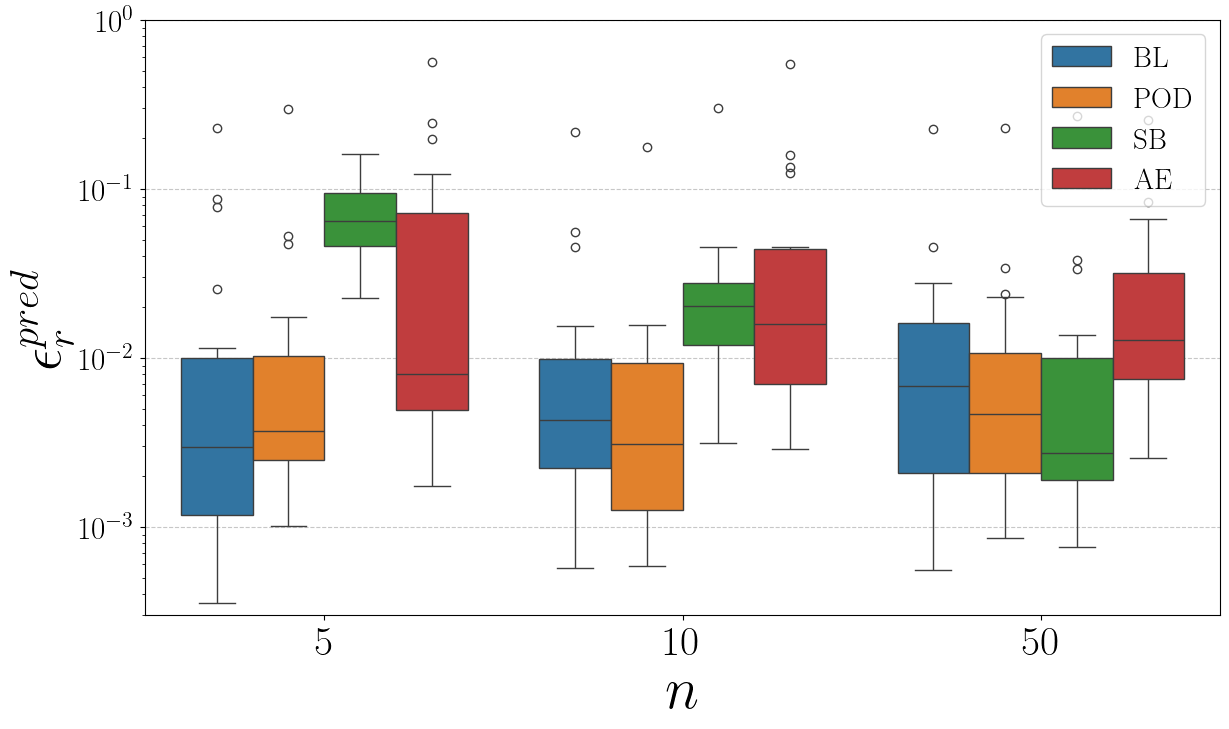

In [22]:
# Paso 1: Resetear el índice para poder filtrar fácilmente
df_reset = error_table.reset_index()

# Paso 2: Filtrar por N_data = 100 y Noise = 0
df_filtered = df_reset.query("N_data == 100 and Noise == 0")

# Paso 3: Expandir los arrays flattened en filas
expanded_rows = []

for _, row in df_filtered.iterrows():
    model = row["Model"]
    mode = row["Mode"]
    error_array = row["pred_error"]
    for error in error_array:
        expanded_rows.append({
            "Model": model,
            "Mode": mode,
            "Error": error
        })

# Paso 4: Crear DataFrame para graficar
plot_df = pd.DataFrame(expanded_rows)

# Paso 5: Hacer el boxplot
import seaborn as sns
import matplotlib.pyplot as plt

name_mapping = {
    "baseline": "BL",
    "POD": "POD",
    "fourier": "SB",
    "autoencoder": "AE"
}
plot_df["Model"] = plot_df["Model"].replace(name_mapping)

# Paso 1: Establecer el orden deseado
model_order = ["BL", "POD", "SB", "AE"]

# Paso 2: Crear paleta personalizada
custom_colors = ["red", "blue", "green", "orange"]
custom_palette = dict(zip(model_order, custom_colors))

# Paso 2: Crear paleta personalizada
custom_colors = ["red", "blue", "green", "orange"]
custom_palette = dict(zip(model_order, custom_colors))


with plt.rc_context({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12*2.5,
    "figure.figsize": (6.5*2, 4.0*2),  # Aproximadamente 0.45\linewidth
    "axes.labelsize": 12*3.5,
    "legend.fontsize": 7*3,
    "xtick.labelsize": 12*2.5,
    "ytick.labelsize": 9*2.5,
}):
    # Paso 3: Graficar con colores personalizados
    plt.figure()
    sns.boxplot(data=plot_df, x="Mode", y="Error", hue="Model", palette='tab10', hue_order=model_order)

    # plt.title("Distribución de errores para N_data = 100 y Noise = 0")
    plt.xlabel(r"$n$")
    plt.ylabel(r'$\epsilon_r^{pred}$')  # etiqueta con LaTeX
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.ylim(3*1e-4, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # ← Solo líneas horizontales
    plt.tight_layout()

    plt.savefig('pred_error_models_N100R0.pdf', bbox_inches='tight', format='pdf')
    plt.show()


In [12]:
sdfasdffas

NameError: name 'sdfasdffas' is not defined

In [ ]:
N = [10, 100, 1000] 
R = [0, 1, 5]
n_modes = [5, 10, 50]
models = ['baseline', 'autoencoder', 'fourier', 'POD']
# models = ['autoencoder']

for model_i in models:

    print(model_i)

    combinations = list(itertools.product(N, R, n_modes))
    n_data_vals, ruido_vals, modos_vals = zip(*combinations)

    # Create the errors table for each model
    multi_index = pd.MultiIndex.from_arrays([n_data_vals, ruido_vals, modos_vals], names=["N_data", "Sigma", "Mode"])
    error_table = pd.DataFrame(index=multi_index, columns=["eQ1", "eQ2", "eQ3", "eK"])

    for n_i in N:
        for r_i in R:
            for mode_i in n_modes:
                
                data_name = f'non_linear_{n_i}_{r_i}'
                model_name = f'{model_i}_model_{mode_i}'
                
                ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
                DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
                RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)


                MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name)

                dataset = load_data(DATA_PATH)

                # Train data splitting in train/test
                X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
                y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
                K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
                f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

                X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

                # Data processing and adequacy with our TensOps library
                X_train = X_train.to(DEVICE)
                X_test = X_test.to(DEVICE)

                y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                # Loading and processing validation data
                X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
                y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

                # Predictive network architecture
                input_shape = X_train[0].shape
                predictive_layers = [20, 10, mode_i, 10, 20]
                predictive_output = y_train.values[0].shape

                # Explanatory network architecture
                explanatory_input = Mx(My(y_train)).values[0].shape
                explanatory_layers = [10]
                explanatory_output = Mx(My(f_train)).values[0].shape

                # Other parameters
                n_filters_explanatory = 5

                if model_i == 'baseline':

                    try:
                        model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'POD':
                    try:
                        if X_train.shape[0] < mode_i:
                            continue

                        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
                        U_reduced_train = U_train[:, :mode_i]
                        S_reduced_train = S_train[:mode_i]
                        Vt_reduced_train = Vt_train[:mode_i, :]
                        POD_base = Vt_reduced_train.to(DEVICE)

                        model = PGNNIVPOD(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                        time = np.cumsum(lists['time_list'])[-1] + time_pod

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'fourier':
                    try:

                        X_mesh = torch.tensor(dataset['X_mesh'])
                        Y_mesh = torch.tensor(dataset['Y_mesh'])

                        base = compute_fourier_base(mode_i, X_mesh, Y_mesh)

                        

                        model = PGNNIVFourier(input_shape, predictive_layers, base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    
                    except:
                        pass

                elif model_i == 'autoencoder':
                    try:
                        MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
                        MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

                        autoencoder_input_shape = y_train.values[0].shape
                        latent_space_dim = [20, 10, mode_i, 10, 20]
                        autoencoder_output_shape = y_train.values[0].shape

                        autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                        autoencoder, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                        hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

                        time_ae = np.cumsum(lists['time_list'])[-1]

                        pretrained_encoder = autoencoder.encoder
                        pretrained_decoder = autoencoder.decoder

                        for param in pretrained_decoder.parameters():
                            param.requires_grad = False

                        pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                        model, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=DEVICE)

                        time = time_ae + np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                u_train = y_val.values.detach().numpy() 
                u_predicted_train = model(X_val)[0].detach().numpy() 
                er_u_train = relative_error(u_train, u_predicted_train).flatten()

                erQ1_u = np.percentile(er_u_train, 25)
                erQ2_u = np.percentile(er_u_train, 50)
                erQ3_u = np.percentile(er_u_train, 75)

                u_min = u_train.flatten().min()
                u_max = u_train.flatten().max()
                steps = 1000
                u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
                K_for_validating = (u_for_validating*(1-u_for_validating)).detach().cpu().numpy()
                K_predicted_for_validating = model.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
                diff_squared = (K_predicted_for_validating - K_for_validating) ** 2
                true_squared = K_for_validating ** 2
                u_vals = u_for_validating.numpy().flatten()
                numerator = np.sqrt(np.trapz(diff_squared.flatten(), u_vals))
                denominator = np.sqrt(np.trapz(true_squared.flatten(), u_vals))

                er_K_train = numerator / denominator


                # K_train_ = Mx(My(K_train)).values.detach().numpy() 
                # K_predicted_train = model(X_train)[1].detach().numpy()
                # er_K_train = er_sum(K_train_, K_predicted_train)
                tiempo_minutos = time / 60

                idx = (n_i, r_i, mode_i)
                # error_table.loc[idx, "Hyperparameters"] = hyperparameters
                # error_table.loc[idx, "time"] = f"{tiempo_minutos:.2f}"
                error_table.loc[idx, "eQ1"] = f"{erQ1_u:.2e}"
                error_table.loc[idx, "eQ2"] = f"{erQ2_u:.2e}"
                error_table.loc[idx, "eQ3"] = f"{erQ3_u:.2e}"
                error_table.loc[idx, "eK"] = f"{er_K_train:.2e}"
                

    print(model_i)
    print(error_table)
    tiempo_segundos = time
    tiempo_minutos = tiempo_segundos / 60
    print(f"Tiempo actual en segundos: {tiempo_segundos}")
    print(f"Tiempo actual en minutos: {tiempo_minutos}")
    print("\n")
                

    # tabla_latex = dataframe_a_latex(error_table, 
    #                                 nombre_archivo=os.path.join(os.getcwd(), "error_tables", f"error_{model_i}"), 
    #                                 index=multi_index,
    #                                 caption="Tabla con formato LaTeX",
    #                                 label="tab:formateada")

baseline
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_1

In [ ]:
N = [10, 100, 1000] 
R = [0, 1, 5]
n_modes = [5, 10, 50]
models = ['baseline', 'POD', 'autoencoder', 'fourier']

# Create the errors table for each model
multi_index = pd.MultiIndex.from_arrays([n_data_vals, ruido_vals, modos_vals], names=["N_data", "Sigma", "Mode"])
error_table = pd.DataFrame(index=multi_index, columns=["baseline", "fourier", "POD", "autoencoder"])

for model_i in models:

    print(model_i)

    combinations = list(itertools.product(N, R, n_modes))
    n_data_vals, ruido_vals, modos_vals = zip(*combinations)



    for n_i in N:
        for r_i in R:
            for mode_i in n_modes:
                
                data_name = f'non_linear_{n_i}_{r_i}'
                model_name = f'{model_i}_model_{mode_i}'
                
                ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
                DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
                RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)

                MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name)

                dataset = load_data(DATA_PATH)

                # Train data splitting in train/test
                X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
                y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
                K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
                f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

                X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

                # Data processing and adequacy with our TensOps library
                X_train = X_train.to(DEVICE)
                X_test = X_test.to(DEVICE)

                y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                # Loading and processing validation data
                X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
                y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

                # Predictive network architecture
                input_shape = X_train[0].shape
                predictive_layers = [20, 10, mode_i, 10, 20]
                predictive_output = y_train.values[0].shape

                # Explanatory network architecture
                explanatory_input = Mx(My(y_train)).values[0].shape
                explanatory_layers = [10]
                explanatory_output = Mx(My(f_train)).values[0].shape

                # Other parameters
                n_filters_explanatory = 5

                if model_i == 'baseline':

                    try:
                        model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'POD':
                    try:
                        if X_train.shape[0] < mode_i:
                            continue

                        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
                        U_reduced_train = U_train[:, :mode_i]
                        S_reduced_train = S_train[:mode_i]
                        Vt_reduced_train = Vt_train[:mode_i, :]
                        POD_base = Vt_reduced_train.to(DEVICE)

                        model = PGNNIVPOD(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                        time = np.cumsum(lists['time_list'])[-1] + time_pod

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                elif model_i == 'fourier':
                    try:

                        X_mesh = torch.tensor(dataset['X_mesh'])
                        Y_mesh = torch.tensor(dataset['Y_mesh'])

                        base = compute_fourier_base(mode_i, X_mesh, Y_mesh)

                        

                        model = PGNNIVFourier(input_shape, predictive_layers, base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                    
                    except:
                        pass

                elif model_i == 'autoencoder':
                    try:
                        MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
                        MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

                        autoencoder_input_shape = y_train.values[0].shape
                        latent_space_dim = [20, 10, mode_i, 10, 20]
                        autoencoder_output_shape = y_train.values[0].shape

                        autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                        autoencoder, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                        hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

                        time_ae = np.cumsum(lists['time_list'])[-1]

                        pretrained_encoder = autoencoder.encoder
                        pretrained_decoder = autoencoder.decoder

                        for param in pretrained_decoder.parameters():
                            param.requires_grad = False

                        pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                        model, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=DEVICE)

                        time = time_ae + np.cumsum(lists['time_list'])[-1]

                        hyperparameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

                    except:
                        pass

                u_train = y_val.values.detach().numpy() 
                u_predicted_train = model(X_val)[0].detach().numpy() 
                er_u_train = relative_error(u_train, u_predicted_train).flatten()

                erQ1_u = np.percentile(er_u_train, 25)
                erQ2_u = np.percentile(er_u_train, 50)
                erQ3_u = np.percentile(er_u_train, 75)

                u_min = u_train.flatten().min()
                u_max = u_train.flatten().max()
                steps = 1000
                u_for_validating = torch.linspace(u_min, u_max, steps=steps).view(steps, 1, 1, 1)
                K_for_validating = (u_for_validating*(1-u_for_validating)).detach().cpu().numpy()
                K_predicted_for_validating = model.explanatory(u_for_validating.to(DEVICE)).detach().cpu().numpy()
                diff_squared = (K_predicted_for_validating - K_for_validating) ** 2
                true_squared = K_for_validating ** 2
                u_vals = u_for_validating.numpy().flatten()
                numerator = np.sqrt(np.trapz(diff_squared.flatten(), u_vals))
                denominator = np.sqrt(np.trapz(true_squared.flatten(), u_vals))

                er_K_train = numerator / denominator


                # K_train_ = Mx(My(K_train)).values.detach().numpy() 
                # K_predicted_train = model(X_train)[1].detach().numpy()
                # er_K_train = er_sum(K_train_, K_predicted_train)
                tiempo_minutos = time / 60

                idx = (n_i, r_i, mode_i)
                # error_table.loc[idx, "Hyperparameters"] = hyperparameters
                # error_table.loc[idx, "time"] = f"{tiempo_minutos:.2f}"
                error_table.loc[(n_i, r_i, mode_i), model_i] = tiempo_minutos


error_table["fourier"] = (error_table["fourier"] / error_table["baseline"])
error_table["POD"] = (error_table["POD"] / error_table["baseline"])
error_table["autoencoder"] = (error_table["autoencoder"] / error_table["baseline"])


error_table = error_table.drop(columns="baseline")

print(model_i)
print(error_table)
tiempo_segundos = time
tiempo_minutos = tiempo_segundos / 60
print(f"Tiempo actual en segundos: {tiempo_segundos}")
print(f"Tiempo actual en minutos: {tiempo_minutos}")
print("\n")

            

# tabla_latex = dataframe_a_latex(error_table, 
#                                 nombre_archivo=os.path.join(os.getcwd(), "error_tables", f"time_prop"), 
#                                 index=multi_index,
#                                 caption="Tabla con formato LaTeX",
#                                 label="tab:formateada")

baseline
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_0\non_linear_10_0.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_10_1\non_linear_10_1.pkl
Data successfully loaded from: c:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data/non_linear_1

In [ ]:
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu
import numpy as np

error_table['Baseline'] = 1.0
for col in ['fourier', 'POD', 'autoencoder']:
    error_table[col] = pd.to_numeric(error_table[col], errors='coerce')

df = error_table.reset_index()

def mannwhitneyu_test(D, method):

    comp_df = df[df['N_data'] == D].dropna(subset=[method])
    stat, p = mannwhitneyu(comp_df[method], comp_df['Baseline'], alternative='less')

    return stat, p

datasets = [10, 100, 1000]
methods = ['fourier', 'POD', 'autoencoder']

for dataset_i in datasets:
    print(f"Dataset D={dataset_i}")
    for method in methods:
        stat, p = mannwhitneyu_test(dataset_i, method)
        
        if p < 0.001:
            stars = '***'
        elif p < 0.01:
            stars = '**'
        elif p < 0.05:
            stars = '*'
        else:
            stars = ''
        
        print(f"Wilcoxon test between Baseline and {method}: p-value={p:.2e} {stars}")
    print("\n")


Dataset D=10
Wilcoxon test between Baseline and fourier: p-value=8.05e-05 ***
Wilcoxon test between Baseline and POD: p-value=3.18e-02 *
Wilcoxon test between Baseline and autoencoder: p-value=1.00e+00 


Dataset D=100
Wilcoxon test between Baseline and fourier: p-value=8.05e-05 ***
Wilcoxon test between Baseline and POD: p-value=8.05e-05 ***
Wilcoxon test between Baseline and autoencoder: p-value=9.99e-01 


Dataset D=1000
Wilcoxon test between Baseline and fourier: p-value=8.05e-05 ***
Wilcoxon test between Baseline and POD: p-value=8.05e-05 ***
Wilcoxon test between Baseline and autoencoder: p-value=8.05e-05 ***


